분류 성능비교
==

다루는 내용
--
- 분류 알고리즘 비교
- 리지 규제, 라쏘 규제
- 교차검증
- 정적 성능평가 Confusion matrix  
- 동적 성능평가 ROC

데이터
--
- 포도주 품질 분류 https://goo.gl/Gyc8K7



모듈 불러오기
--

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier 
from sklearn.svm import SVC 
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score 
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
!curl -L https://goo.gl/Gyc8K7 -o wine.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100   98k  100   98k    0     0  48698      0  0:00:02  0:00:02 --:--:-- 48698


데이터 읽기 (포도주 품질 평가)
--

In [8]:
wine = pd.read_csv('wine.csv')
print(wine.shape)
wine.head(5)

(1599, 12)


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


- fixed acidity - 결합 산도 
- volatile acidity - 휘발성 산도 
- citric acid - 시트르산 
- residual sugar - 잔류 설탕 
- chlorides	 - 염화물 
- free sulfur dioxide - 자유 이산화황 
- total sulfur dioxide - 총 이산화황 
- density - 밀도 
- pH - pH 
- sulphates - 황산염 
- alcohol - 알코올 
- quality - 품질 (0 ~ 10 점)

In [9]:
wine.info() # 데이터 정보

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
fixed acidity           1599 non-null float64
volatile acidity        1599 non-null float64
citric acid             1599 non-null float64
residual sugar          1599 non-null float64
chlorides               1599 non-null float64
free sulfur dioxide     1599 non-null float64
total sulfur dioxide    1599 non-null float64
density                 1599 non-null float64
pH                      1599 non-null float64
sulphates               1599 non-null float64
alcohol                 1599 non-null float64
quality                 1599 non-null int64
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [10]:
wine.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')

## 데이터 전처리 (레이블 만들기)

In [11]:
wine['quality'].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [12]:
# 품질이 좋고 나쁜 것을 나누는 기준 설정
# 6.5를 기준으로 bad(0) good(1)으로 나눈다 (임의로 나눈 것임)
my_bins = (2.5, 6.5, 8.5)
groups = [0, 1]
wine['qual'] = pd.cut(wine['quality'], bins = my_bins, labels = groups) 

wine['qual'].value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [13]:
X = wine.drop(['quality', 'qual'], axis = 1) 
y = wine['qual'] 

y.value_counts()

0    1382
1     217
Name: qual, dtype: int64

In [14]:
X[:3]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8


표준 스케일링
--

전체 자료의 분포를 평균 0, 분산 1이 되도록 만든다.  
X에는 수치 데이터만 들어야 한다.  
테스트 데이터도 같이 스케일링하는 것을 잊지 않는다

In [0]:
sc = StandardScaler()
X = sc.fit_transform(X)

In [16]:
X[:3]

array([[-0.52835961,  0.96187667, -1.39147228, -0.45321841, -0.24370669,
        -0.46619252, -0.37913269,  0.55827446,  1.28864292, -0.57920652,
        -0.96024611],
       [-0.29854743,  1.96744245, -1.39147228,  0.04341614,  0.2238752 ,
         0.87263823,  0.62436323,  0.02826077, -0.7199333 ,  0.1289504 ,
        -0.58477711],
       [-0.29854743,  1.29706527, -1.18607043, -0.16942723,  0.09635286,
        -0.08366945,  0.22904665,  0.13426351, -0.33117661, -0.04808883,
        -0.58477711]])

In [17]:
# 데이터를 랜덤하게 섞은 후 80%를 훈련데이터로 사용
np.random.seed(11)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, y_train.shape
# X_test.shape, y_test.shape

((1279, 11), (1279,))

## 선형 모델(확률적 경사 하강법 사용)

In [18]:
sgd = SGDClassifier()
sgd.fit(X_train, y_train)
sgd.score(X_test,y_test)

0.81875

결정 트리 (Decesion Tree)
--

In [19]:
from sklearn import tree
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)
clf.score(X_test,y_test)

0.871875

## 랜덤 포래스트 (Random Forest Classifier)

In [20]:
rfc = RandomForestClassifier(n_estimators=300) 
rfc.fit(X_train, y_train)
rfc.score(X_test,y_test)

0.91875

## Support Vector Classifier (SVC)

In [21]:
svc = SVC()
svc.fit(X_train, y_train)
svc.score(X_test,y_test)

0.88125

Logistic Regression
--

In [22]:
log = LogisticRegression()
log.fit(X_train, y_train)
log.score(X_test,y_test)

0.86875

## Cross validation(교차 검증)

In [23]:
# estimator = 모델, cv는 분할 테스트 숫자
rfc_eval = cross_val_score(rfc, X = X, y = y, cv = 5)  
rfc_eval  # 5번의 교차 검증 결과를 보여준다

array([0.875     , 0.853125  , 0.88125   , 0.86875   , 0.88401254])

In [24]:
rfc_eval.mean()

0.8724275078369906

##  정적 평가, 혼돈 매트릭스 (confusion_matrix)

In [25]:
y_pred = sgd.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[253,  16],
       [ 42,   9]])

아래는 모델이 올바르게 예측했는지를 평가하기 위한 값들이다

In [26]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       269
           1       0.36      0.18      0.24        51

    accuracy                           0.82       320
   macro avg       0.61      0.56      0.57       320
weighted avg       0.78      0.82      0.79       320



- Precision  = 모델이 옳다고 한 것이 실제로 옳은 비율     TP / ( TP + FP ) 
- Recall =  실제 정답인 것들 중, 모델이 정답이라고 예측한 것    TP / TP+FN
- f1-score = Precision과 Recall의 조화평균  (2 x  Precision x Recall ) /  (Precision + Recall)
- support는 이 모델에서 응답한 샘플의 수이다

Score (맞다고 생각하는 점수)
--

In [0]:
y_score = sgd.decision_function(X_test)

In [28]:
y_score

array([ 0.79259076, -2.95713556, -5.74014753, -1.21517746, -5.88022051,
       -4.42777971, -0.76860216, -3.34392001, -1.47694009, -3.31226788,
       -2.05212467, -1.51212077, -3.3233555 , -4.88397478, -4.50375998,
       -4.63594722, -6.26946319,  0.14152515, -3.84071409, -3.00798083,
       -6.88089061, -1.990497  , -3.42547395, -1.20347495, -1.63223929,
       -1.06663467, -5.59403311, -1.86875888, -3.10658581, -3.6248215 ,
       -2.52024911, -3.98998698, -0.57899472, -0.38765539, -0.85002164,
       -3.07604878, -3.19202795,  3.15760803, -3.46875434, -3.50689592,
       -3.85075402, -5.74308399, -3.85463225, -6.35065911, -2.51102374,
       -2.16363303, -1.50943016, -0.9715362 , -4.29387116, -4.05287898,
       -1.5730235 , -1.11008415, -2.72885914, -0.01643219, -1.63223929,
       -1.31506335, -4.76713174, -4.06794999, -0.84256198, -4.56679545,
       -7.70516317, -4.16289452, -1.70850099, -1.30066144, -1.11091483,
       -3.79657294, -1.74505586, -4.78720734, -3.66057253, -3.96

랭킹 (순서를 평가)
--

In [29]:
result = pd.DataFrame(list(zip(y_score, y_pred, y_test)), 
                      columns=['score', 'predict', 'real'])
result['correct'] = (result.predict == result.real)
result.head()

,score,predict,real,correct
0,0.792591,1,0,False
1,-2.957136,0,0,True
2,-5.740148,0,0,True
3,-1.215177,0,0,True
4,-5.880221,0,0,True


ROC로 성능 평가 (맞춘 순서를 평가)
--

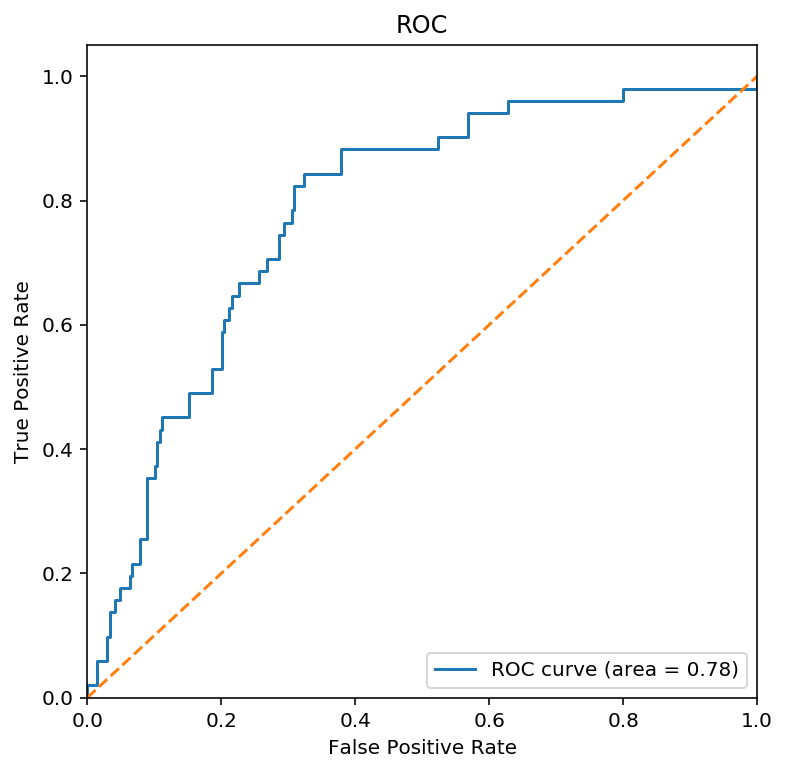

In [30]:
fpr = dict()
tpr = dict()
roc_auc = dict()
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")